In [3]:
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import functools

## define function for printing pandas dataframes as markdown (in case it is needed)

In [2]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function to round values in an interval object

In [4]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## load saved patient info

In [13]:
patient_df = pds.read_csv('triplestore-patient-info.tsv', sep='\t')

# Plot data

## plot get patient counts by gender

In [14]:
gender_count = patient_df.gender.value_counts()
gender_count.loc['total'] = len(patient_df)
gender_count

female    126692
male      100106
total     226798
Name: gender, dtype: int64

In [15]:
# print_pandas_md(pds.DataFrame(gender_count)) # in case I need the table in markdown

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


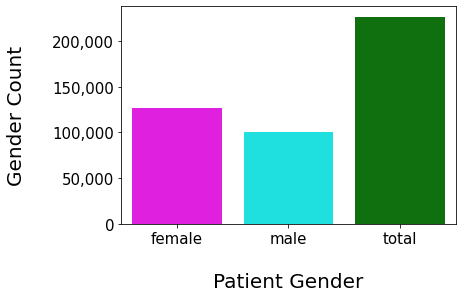

In [16]:
%matplotlib inline

# plot gender counts
# ax = sns.countplot(x="gender", data=group)
colors = ['magenta', 'cyan', 'green']
sns.set_palette(colors)
ax = sns.barplot(x=gender_count.index, y=gender_count.values)
ax.set_xlabel("\nPatient Gender", size=20)
ax.set_ylabel("Gender Count\n", size=20)
plt.xticks(size=15)
plt.yticks(size=15)

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.savefig("figures/patient-gender-counts.png", dpi=600, bbox_inches="tight")
plt.show()

## calculate age distributions and plot

In [17]:
age_table = \
    pds.DataFrame(pds.cut(patient_df['patient_age'], 10).value_counts().sort_index()).reset_index()
age_table.rename(columns={'index': 'Age Range', 'patient_age': 'Total'}, inplace=True)
age_table['Age Range'] = age_table['Age Range'].map(lambda x: round_interval(x))
age_table['Percent'] = round((age_table['Total'] / 226798) * 100, 1)
# print_pandas_md(age_table)
age_table.to_clipboard()
age_table

,Age Range,Total,Percent
0,"[2, 13)",8502,3.7
1,"[13, 24)",32092,14.2
2,"[24, 36)",42110,18.6
3,"[36, 47)",42205,18.6
4,"[47, 58)",43160,19.0
5,"[58, 69)",32554,14.4
6,"[69, 80)",17389,7.7
7,"[80, 92)",7275,3.2
8,"[92, 103)",1409,0.6
9,"[103, 114)",102,0.0


/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
No handles with labels found to put in legend.


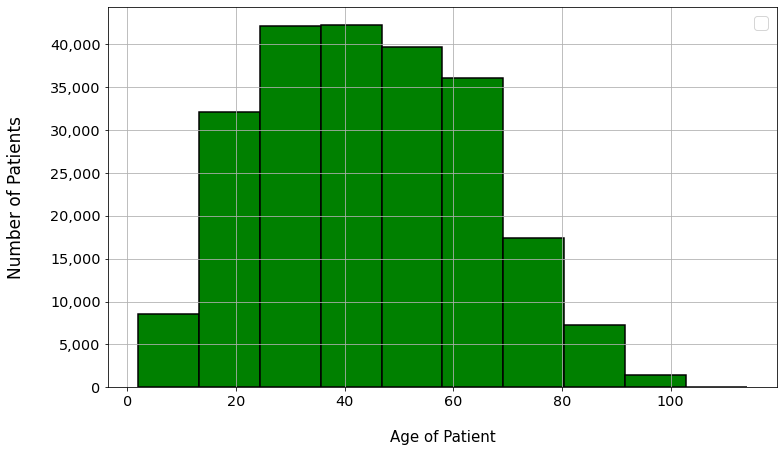

In [18]:
%matplotlib inline

# plot age distribution
ax = patient_df['patient_age']\
        .hist(bins=10, color='green', edgecolor='black', linewidth=1.5,figsize=(12,7))

ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Number of Patients\n", fontsize=17)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.legend(loc='upper right', prop={'size': 18})
plt.savefig("figures/patient-age-distribution.png", dpi=600, bbox_inches="tight")
plt.show()

### use the same intervals for females and males that was used for the total age distribution

In [19]:
age_bins = pds.IntervalIndex(age_table['Age Range'])
age_bins

IntervalIndex([[2, 13), [13, 24), [24, 36), [36, 47), [47, 58), [58, 69), [69, 80), [80, 92), [92, 103), [103, 114)],
              closed='left',
              name='Age Range',
              dtype='interval[int64]')

### calculate female age intervals

In [20]:
females = patient_df.query("gender == 'female'")['patient_age']
female_age_table = \
    pds.DataFrame(pds.cut(females, age_bins).value_counts().sort_index()).reset_index()
female_age_table.rename(columns={'index': 'Age Range', 'patient_age': 'Total'}, inplace=True)
female_age_table['Age Range'] = female_age_table['Age Range'].map(lambda x: round_interval(x))
female_age_table['Percent Female'] = round((female_age_table['Total'] / 226798) * 100, 1)
# print_pandas_md(female_age_table)
female_age_table.to_clipboard()
female_age_table

,Age Range,Total,Percent Female
0,"[2, 13)",3451,1.5
1,"[13, 24)",15690,6.9
2,"[24, 36)",26056,11.5
3,"[36, 47)",24658,10.9
4,"[47, 58)",22545,9.9
5,"[58, 69)",18790,8.3
6,"[69, 80)",10110,4.5
7,"[80, 92)",4464,2.0
8,"[92, 103)",858,0.4
9,"[103, 114)",69,0.0


### calculate male age intervals

In [21]:
males = patient_df.query("gender == 'male'")['patient_age']
male_age_table = \
    pds.DataFrame(pds.cut(males, age_bins).value_counts().sort_index()).reset_index()
male_age_table.rename(columns={'index': 'Age Range', 'patient_age': 'Total'}, inplace=True)
male_age_table['Age Range'] = male_age_table['Age Range'].map(lambda x: round_interval(x))
male_age_table['Percent Male'] = round((male_age_table['Total'] / 226798) * 100, 1)
# print_pandas_md(male_age_table)
male_age_table.to_clipboard()
male_age_table

,Age Range,Total,Percent Male
0,"[2, 13)",3228,1.4
1,"[13, 24)",14656,6.5
2,"[24, 36)",19623,8.7
3,"[36, 47)",17547,7.7
4,"[47, 58)",17105,7.5
5,"[58, 69)",14802,6.5
6,"[69, 80)",8793,3.9
7,"[80, 92)",3769,1.7
8,"[92, 103)",551,0.2
9,"[103, 114)",32,0.0


### plot female/male age distribution

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


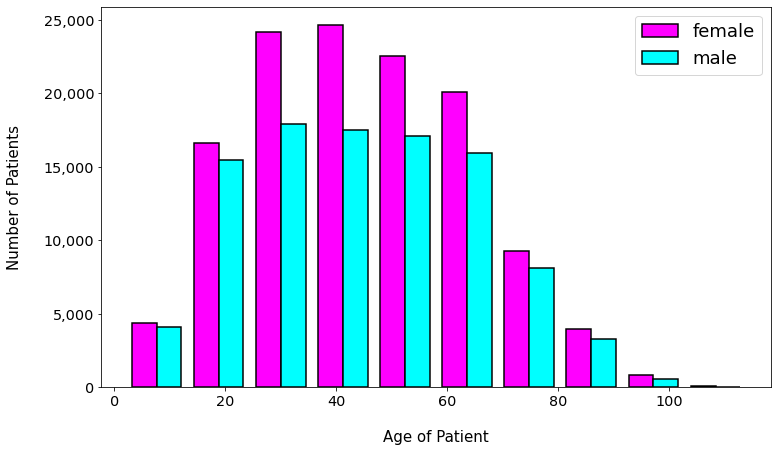

In [26]:
%matplotlib inline
colors = ['magenta', 'cyan']
sns.set_palette(colors)

# create separate series for genders
females = patient_df.query("gender == 'female'")['patient_age']
males = patient_df.query("gender == 'male'")['patient_age']

fig, ax = plt.subplots(figsize=(12,7)) 
ax.hist([females, males], bins=10, edgecolor='black', linewidth=1.5, label=['female', 'male'])
ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Number of Patients\n", fontsize=15)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.figure(figsize=(12,7))
plt.legend(loc='upper right', prop={'size': 18})
plt.savefig("figures/patient-age-gender-distribution.png", dpi=600, bbox_inches="tight")
plt.show()

In [23]:
############ OLD CODE ###########
# %matplotlib inline

# # plot age/gender distribution
# ax = df_females["patient_age"]\
#         .hist(bins=10, alpha=0.5, color='magenta', label='female', edgecolor='black', linewidth=1.5,figsize=(12,7))
# ax = df_males["patient_age"]\
#         .hist(bins=10, alpha=0.5, color='cyan', label='male', edgecolor='black', linewidth=1.5, figsize=(12,7))

# ax.set_xlabel("\nAge of Patient", fontsize=15)
# ax.set_ylabel("Number of Patients\n", fontsize=17)

# ax.tick_params(labelsize='x-large') # use large labels
# plt.xticks(rotation=0)  # rotate the ticks on the x axis

# ## put commas in y-ticks
# ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# plt.legend(loc='upper right', prop={'size': 18})
# plt.savefig("figures/patient-age-gender-distribution.png", dpi=600, bbox_inches="tight")
# plt.show()